In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import warnings

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

# Make a laundry list of preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
# https://gist.github.com/AdamSpannbauer/c99c366b0c7d5b6c4920a46c32d738e5
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

* Read in and get to know the data.  We want to eventually predict `Profit`

In [4]:
data_url = "https://docs.google.com/spreadsheets/d/1RJrLftlRnj6gmrYewqxykVKSyl7aV-Ktd3sUNQILidM/export?format=csv"

<IPython.core.display.Javascript object>

In [5]:
df = pd.read_csv(data_url)
df.head(3)

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39


<IPython.core.display.Javascript object>

In [6]:
df.isna().sum()

R&D Spend          0
Administration     0
Marketing Spend    0
State              0
Profit             0
dtype: int64

<IPython.core.display.Javascript object>

In [7]:
df.dtypes

R&D Spend          float64
Administration     float64
Marketing Spend    float64
State               object
Profit             float64
dtype: object

<IPython.core.display.Javascript object>

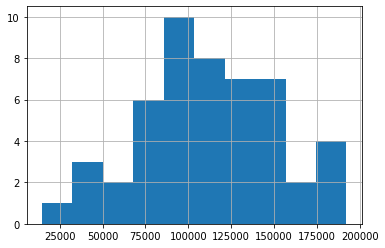

<IPython.core.display.Javascript object>

In [8]:
# Any extreme skew to address?
df["Profit"].hist()
plt.show()

* Do we have an even distribution of states?  We'll eventually encode this variable to be numeric, how should we encode it? Which category would be the 'default'?

In [9]:
df["State"].value_counts()

California    17
New York      17
Florida       16
Name: State, dtype: int64

<IPython.core.display.Javascript object>

* Create a pair plot with all of the data, what do you see?

In [10]:
# sns.pairplot(df, hue="State")
# plt.show()

<IPython.core.display.Javascript object>

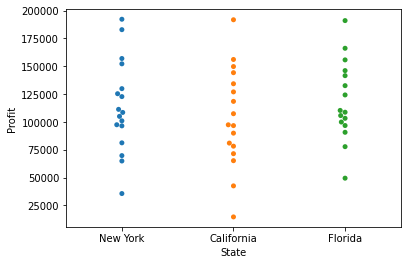

<IPython.core.display.Javascript object>

In [11]:
sns.swarmplot(x="State", y="Profit", data=df)
plt.show()

* Create a train test split stratified by state

In [12]:
X = df.drop(columns=["Profit"])
y = df["Profit"]

<IPython.core.display.Javascript object>

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=X["State"]
)

<IPython.core.display.Javascript object>

* One hot encode

We'll take a look at using the `ColumnTransformer` today.  This is a way to write a 1 stop shop for all of your column preprocessing for a supervised learning model.  We can use it to one hot encode categorical variables and scale numeric variables all at once.

In [14]:
X_train.head(1)

,R&D Spend,Administration,Marketing Spend,State
11,100671.96,91790.61,249744.55,California


<IPython.core.display.Javascript object>

In [15]:
# Not an obvious default according to these counts
# so choose default based on business case

# We are a company based in CA
X_train["State"].value_counts()

New York      14
Florida       13
California    13
Name: State, dtype: int64

<IPython.core.display.Javascript object>

In [16]:
# List out what types of data you have
cat_cols = ["State"]  # Things i want to encode (maybe dummy/onehotencoding)
drop_cats = ["California"]  # Which dummy column to drop to avoid multicollinearity

num_cols = [
    "R&D Spend",
    "Administration",
    "Marketing Spend",
]  # Things i might want to scale

bin_cols = []  # Things i dont want to touch

<IPython.core.display.Javascript object>

----

Option showing how to onehotencode and scale numerics

In [17]:
# Define our preprocessing pipeline (aka column transformer)
preprocessing = ColumnTransformer(
    [
        # Each step has format:
        # ('name_of_step', PreProcessor(), list_of_colums_to_process)
        ("encode_cats", OneHotEncoder(drop=drop_cats), cat_cols),
        ("scale_nums", StandardScaler(), num_cols),
    ]
)

<IPython.core.display.Javascript object>

Option showing how to onehotencode and leave numerics untouched

In [18]:
# Preprocessing without scaling num_cols
# Any columns not mentioned in a processing step,
# will be handled by `remainder` parameter
# to do nothing say 'passthrough'

# fmt: off
preprocessing = ColumnTransformer([
    ("encode_cats", OneHotEncoder(drop=drop_cats), cat_cols),
], remainder = 'passthrough')

<IPython.core.display.Javascript object>

----

A big benefit of this is a single `fit` method that figures out how to one hot encode and scale and whatever else all at once.  We also have a single `transform` method that prepares all of our data at once.  This is a big big big plus for being able to predict on new data.

In [19]:
preprocessing.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('encode_cats',
                                 OneHotEncoder(drop=['California']),
                                 ['State'])])

<IPython.core.display.Javascript object>

In [20]:
X_train_trans = preprocessing.transform(X_train)
X_test_trans = preprocessing.transform(X_test)

X_train = pd.DataFrame(X_train_trans, index=X_train.index)
X_test = pd.DataFrame(X_test_trans, index=X_test.index)

X_train.head()

,0,1,2,3,4
11,0.0,0.0,100671.96,91790.61,249744.55
8,0.0,1.0,120542.52,148718.95,311613.29
34,0.0,0.0,46426.07,157693.92,210797.67
1,0.0,0.0,162597.70,151377.59,443898.53
19,0.0,1.0,86419.70,153514.11,0.00


<IPython.core.display.Javascript object>

The downside to this is it's harder to trackdown the variable
names :(

If we don't care about interpretability (just focused
on accuracy), this isn't terrible.  It's annoying if we care
about interpreting, and with linear regression we almost always care about interpreting coefficients.

This is admittedly, a pain.  Ugly code below to address the issue for this model.

In [21]:
cat_names = preprocessing.transformers_[0][1].get_feature_names(cat_cols)
cat_names = list(cat_names)

new_col_names = cat_names + num_cols

X_train.columns = new_col_names
X_test.columns = new_col_names

X_train.head(2)

,State_Florida,State_New York,R&D Spend,Administration,Marketing Spend
11,0.0,0.0,100671.96,91790.61,249744.55
8,0.0,1.0,120542.52,148718.95,311613.29


<IPython.core.display.Javascript object>

Let's try and drive home why this is better than `pd.get_dummies` in a machine learning context.  For our model's to make any difference to the business they need to be 'deployed'; that is, they need to be living somewhere that they can receive new data and make predictions.

Let's say we run a website for people to judge how well a startup would do.  All users need to do is go to our website, fill out a form that asks them for the `'R&D Spend'`, `'Administration'`, `'Marketing Spend'`, and `'State'`.  Given this info, our model is expected to predict how much `'Profit'` we think the startup will have.

^This means that we'll get one new observation at a time.  Below is an example of what a user might input.

In [22]:
new_observation = pd.DataFrame(
    {
        "R&D Spend": [73721],
        "Administration": [121344],
        "Marketing Spend": [211025],
        "State": ["California"],
    }
)

new_observation

,R&D Spend,Administration,Marketing Spend,State
0,73721,121344,211025,California


<IPython.core.display.Javascript object>

For us to make a prediction, we need to reformat this data the same way we reformatted our original data.

In [23]:
# Reminder of what the training data looks like right now.
# Our new observation needs to match for our model to know
# what to do (column names optional, models dont care about them)
X_train.head(2)

,State_Florida,State_New York,R&D Spend,Administration,Marketing Spend
11,0.0,0.0,100671.96,91790.61,249744.55
8,0.0,1.0,120542.52,148718.95,311613.29


<IPython.core.display.Javascript object>

Maybe you'd think to use `pd.get_dummies()`. What's the issue with this?

In [24]:
pd.get_dummies(new_observation)

,R&D Spend,Administration,Marketing Spend,State_California
0,73721,121344,211025,1


<IPython.core.display.Javascript object>

This is where the extra work we put into the `ColumnTransformer()` pays off.

In [25]:
pd.DataFrame(preprocessing.transform(new_observation), columns=new_col_names)

,State_Florida,State_New York,R&D Spend,Administration,Marketing Spend
0,0.0,0.0,73721.0,121344.0,211025.0


<IPython.core.display.Javascript object>

------

* Check for multicollinearity with VIF

In [26]:
print_vif(X_train)

VIF results
-------------------------------
const              27.142316
State_Florida       1.383744
State_New York      1.374142
R&D Spend           2.523572
Administration      1.245072
Marketing Spend     2.234915
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

* Build a model using statsmodels and display the summary
    * Interpret $R^2$

In [27]:
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train_const).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     140.6
Date:                Wed, 09 Dec 2020   Prob (F-statistic):           1.07e-21
Time:                        11:25:45   Log-Likelihood:                -420.68
No. Observations:                  40   AIC:                             853.4
Df Residuals:                      34   BIC:                             863.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            4.905e+04   7985.346      6.142      0.000    3.28e+04    6.53e+04
State_Florida     450.2065   3849.502      0.117      0.908   -7372.923    8273.335
State_New York   -180.1938   3766.997     -0.048      0.962   -7835.653    7475.266
R&D Spend           0.8110      0.052     15.500      0.000       0.705       0.917
Administration     -0.0436      0.062     -0.699      0.489      -0.170       0.083
Marketing Spend     0.0371      0.019      1.946      0.060      -0.002       0.076
==============================================================================
Omnibus:                       11.767   Durbin-Watson:                   1.305
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.712
Skew:                          -0.980   Prob(JB):                      0.00174
Kurtosis:                       4.945   Cond. No.                     1.50e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.5e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>

* Check the normality of residuals assumption with a qqplot

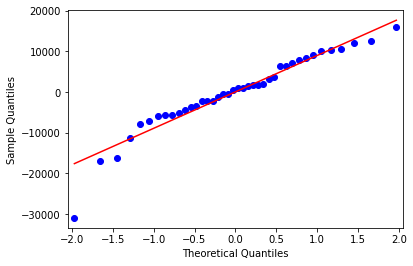

<IPython.core.display.Javascript object>

In [28]:
sm.qqplot(model.resid, line="s")
plt.show()

* Check the homoscedasticity assumption with `statsmodels`

In [29]:
# Null: residuals are homoscedastic
# p > 0.05 indicates this assumption is met
_, p, _, _ = het_breuschpagan(model.resid, X_train_const)
p

0.6440450202856463

<IPython.core.display.Javascript object>

* Make a plot of actuals vs predicted

In [30]:
y_pred = model.predict(X_test_const)

<IPython.core.display.Javascript object>

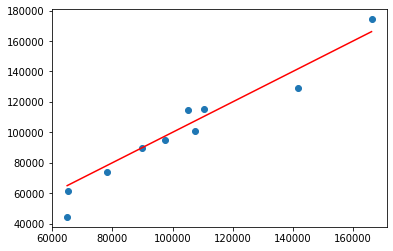

<IPython.core.display.Javascript object>

In [31]:
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c="red")
plt.show()

* Calculate MAE, MAPE, MSE, & RMSE
  * Interpret MAE and MAPE

In [32]:
# Technically these are called residuals
# using error to make Mean Absolute Error fit will with this name
error = y_pred - y_test

<IPython.core.display.Javascript object>

In [33]:
# Calculate the Mean Absolute Error:

# On average, our predictions are
# within $7,376 of the correct answer
np.mean(np.abs(error))

7376.850877927941

<IPython.core.display.Javascript object>

In [34]:
# Calculate the Mean Absolute Percent Error:

# On average, our predictions are
# within 8% of the correct answer
percent_error = error / y_test
np.mean(np.abs(percent_error))

0.08004001475489793

<IPython.core.display.Javascript object>

### Summary:

* Preprocess with `ColumnTransformer`
    * Steps:
        1. List out your datatypes:
            * Categorical data:
                * `cat_cols = ['State']`
                * `drop_cats = ['California']`
            * Numeric data: `num_cols = ['R&D', 'Admin', 'Marketing']`
            * Binary data: `bin_cols = [is_tech_industry]`
        * Define `ColumnTransformer`: see below
        * Learn transformation with `.fit()`
        * Apply learned transformations with `.transform()`
        
* Metrics to evaluate model
    * Mean Absolute Error (MAE):
        * Answer question: "On average, how far off are your predictions?"
        * If MAE = 10 then -> "On average, our predictions are within 10 of the right answer."        
    * Mean Absolute Percent Error (MAPE):
        * Answer question: "On average, how far off are your predictions (percentage wise)?"
        * If MAPE = 0.8 then -> "On average, our predictions are within 8% of the right answer."

```python
# Define our preprocessing pipeline (aka column transformer)
preprocessing = ColumnTransformer(
    [
        # Each step has format:
        # ('name_of_step', PreProcessor(), list_of_colums_to_process)
        ("encode_cats", OneHotEncoder(drop=drop_cats), cat_cols),
        ("scale_nums", StandardScaler(), num_cols),
    ]
)

# Learn
preprocessing.fit(X_train)

# Apply learned transformation
X_train = preprocessing.transform(X_train)
X_test = preprocessing.transform(X_test)
```

-------

#### Group A: 

Re-fit the model, but use either `QuantileTransformer()`, `StandardScaler()`, or `MinMaxScaler()`.

#### Group B:

Re-fit the model, but drop the predictor that was the worst predictor in our original model.

----

* Using the `statsmodels` output as a reference: Is your model performing better, worse, or no different than our original model? Which numbers back this up?
* Use `MAE` to evaluate your model.  Interpret this number for a business person.  According to this metric, how does your model perform compared to the original (again, express this as if you're talking to a business person).

In [35]:
# You can write new code for this or modify the above existing code
# Modifying is prolly less effort


<IPython.core.display.Javascript object>

--------

Let's use `sklearn`'s `cross_val_score` to see a more 'stable' picture of your model's accuracy
* Use `cross_val_score` to calculate $R^2$
    * $R^2$ is the default score
    * We can choose from [a long list of scores](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values) `sklearn` can do for us.

* Use `cross_val_score` with a different score than $R^2$